In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance_matrix
import time
import matplotlib.pyplot as plt

class Neighbours_classifier:

    '''
    LOO method only supports functions that assign boolean weights
    '''
    
    def __init__(self, weight_func, func_params):
        self.weight_func = weight_func
        self.func_params = func_params
        
    def fit(self, data, labels_col):
        self.train = data.drop(columns = labels_col)
        self.labels = data[labels_col]
        self.classes = np.unique(self.labels)
    
    def predict_proba(self, test):
        d_mat = pd.DataFrame(distance_matrix(test, self.train), 
                             index=test.index, columns=self.train.index)
        weighted = self.weight_func(*self.func_params, d_mat)
        self.probas = pd.DataFrame(np.zeros([test.shape[0], len(self.classes)]), 
                                   index=test.index, columns=self.classes)
        for c in self.classes:
            class_cols = self.train.index[self.labels == c]
            self.probas[c] = weighted[class_cols].sum(axis=1)/weighted.sum(axis=1)
        self.probas = self.probas.fillna(0)
        return self.probas
        
    def predict(self, test, threshold=0.5):
        self.predict_proba(test)
        self.preds = self.probas.apply(lambda x: self.probas.columns[x>=threshold][0], axis=1)
        return self.preds
        
    def LOO(self, loo_vals):
        d_mat = pd.DataFrame(distance_matrix(self.train, self.train),
                            index=self.train.index, columns=self.train.index)
        Neighbor_dic , Slice_frame = self.weight_func(*self.func_params, d_mat, 
                                                    LOO=True, loo_vals=loo_vals)
        LOOs = np.zeros(shape=[len(loo_vals)])
        
        for k, v in Neighbor_dic.items():
            temp = np.zeros(shape=[len(loo_vals)])
            for i, param in enumerate(loo_vals):
                neighbor_classes = self.labels[v[:Slice_frame.loc[k, param]]]
                if len(neighbor_classes) == 0:
                    temp[i]+=1
                else:
                    counts = np.bincount(neighbor_classes)
                    most_frequent = np.argmax(counts)
                    if most_frequent != self.labels[k]:
                        temp[i]+=1
            LOOs += temp
        LOOs /= self.train.shape[0]
        #return Neighbor_dic, Slice_frame    
        return loo_vals, LOOs

def measure_time(func):
    def measure_time_wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Weightening done in {end - start} seconds")
        return result
    return measure_time_wrapper

@measure_time
def knn_weight(k, dist_arr, LOO=False, loo_vals=None):
    if LOO:
        *_, kmax = loo_vals
        Neighbor_dic = {}
        for i, row in dist_arr.iterrows():
            neighbor_indices = row.sort_values().index[:kmax+1]
            selfind = np.argwhere(neighbor_indices==i)
            Neighbor_dic[i] = np.delete(neighbor_indices, selfind)
        Slice_frame = pd.DataFrame([list(range(1, kmax+1)) for _ in range(dist_arr.shape[0])], 
                                   index=dist_arr.index, columns=loo_vals)
        return Neighbor_dic, Slice_frame
    else:
        weighted = pd.DataFrame(np.full(dist_arr.shape, False),
                            index=dist_arr.index, columns=dist_arr.columns)
        for i, row in dist_arr.iterrows():
            neighbor_indices = row.sort_values().index[:k]
            weighted.loc[i, neighbor_indices] = True
        return weighted

@measure_time
def radius_weight(r, dist_arr, LOO = False, loo_vals=None):
    if LOO:
        rmax = loo_vals[-1]
        Neighbor_dic = {}
        Slice_frame = pd.DataFrame(index=dist_arr.index, columns=loo_vals)
        for i, row in dist_arr.iterrows():
            temp = row.drop(i).sort_values()
            temp = temp[temp<=rmax]
            Neighbor_dic[i] = temp.index
            Slice_frame.loc[i, rmax] = len(temp)
            for param in loo_vals[-2::-1]:
                temp = temp[temp<=param]
                Slice_frame.loc[i, param] = len(temp)
        return Neighbor_dic, Slice_frame
    else:
        weighted = pd.DataFrame(np.full(dist_arr.shape, False),
                               index=dist_arr.index, columns=dist_arr.columns)
        for i, row in dist_arr.iterrows():
            neighbor_indices = row.index[row<=r]
            weighted.loc[i, neighbor_indices] = True
        return weighted

## KNN-classifier

Classifying datasets containing numeric characteristics of malignant and benign tumors:

In [2]:
df_cancer = pd.read_csv('Data/cancer.csv')
print(df_cancer.shape)
df_cancer.head()

(569, 31)


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Making labels binary

In [3]:
df_cancer['label'], lab_enc_cancer = pd.factorize(df_cancer['label'])
print(lab_enc_cancer)
df_cancer.head()

Index(['M', 'B'], dtype='object')


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Splitting the data into train and test samples, performing classification.

In [4]:
Train_c, Test_c = train_test_split(df_cancer, test_size = 0.2, stratify = df_cancer['label'])
Test_labels_c = Test_c['label']
Test_c = Test_c.drop(columns = 'label')

In [114]:
model = Neighbours_classifier(knn_weight, [10])
model.fit(Train_c, 'label')
probas_c = model.predict_proba(Test_c)
print(f'ROC-AUC score of the model: {roc_auc_score(Test_labels_c, probas_c.iloc[:,1])}')

Weightening done in 0.22688889503479004 seconds
ROC-AUC score of the model: 0.9755291005291005


Computing LOO on the whole dataset for values of $k=1,2,...,10$

In [117]:
model.fit(df_cancer, 'label')
lvs, LOOs = model.LOO(list(range(1, 11)))

Weightening done in 0.30313801765441895 seconds


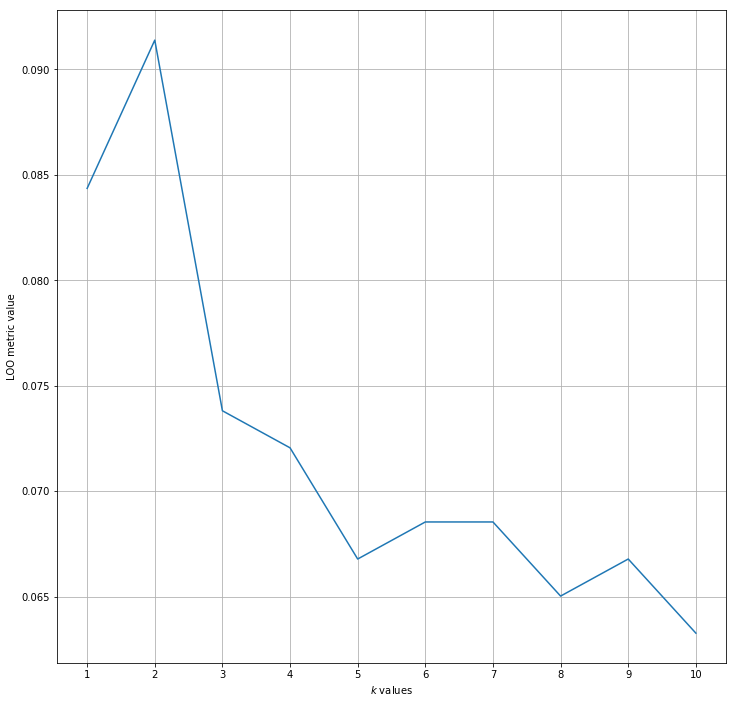

In [119]:
fig, ax = plt.subplots(figsize=[12, 12])
ax.plot(lvs, LOOs)
ax.set_xticks(lvs)
ax.grid()
ax.set_xlabel('$k$ values')
_ = ax.set_ylabel('LOO metric value')

Now, let's use KNN algorithm to classify spam mail:

In [59]:
df_spam = pd.read_csv('Data/spam.csv')
print(df_spam.shape)
df_spam.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [60]:
Train_s, Test_s = train_test_split(df_spam, test_size=0.2, stratify=df_spam['label'])
Test_labels_s = Test_s['label']
Test_s = Test_s.drop(columns='label')

In [101]:
model = Neighbours_classifier(knn_weight, [10])
model.fit(Train_s, labels_col='label')
probas_s = model.predict_proba(Test_s)
print(f'ROC-AUC score of the model: {roc_auc_score(Test_labels_s, probas_s.iloc[:,1])}')

Weightening done in 65.00014185905457 seconds
ROC-AUC score of the model: 0.8588968867561244


LOO:

In [120]:
model.fit(df_spam, 'label')
lvs_s, LOOs_s = model.LOO(list(range(1, 11)))

Weightening done in 3.34818959236145 seconds


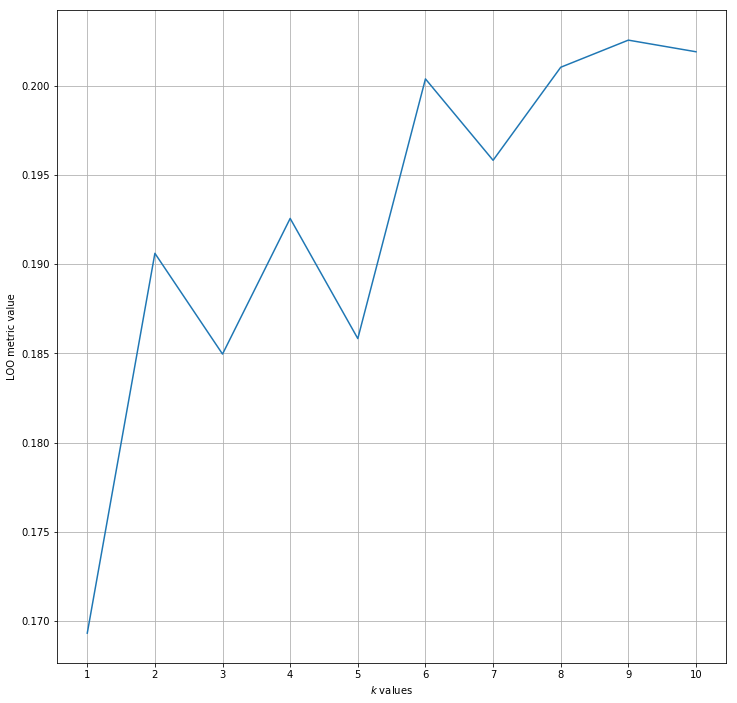

In [121]:
fig, ax = plt.subplots(figsize=[12, 12])
ax.plot(lvs_s, LOOs_s)
ax.set_xticks(lvs_s)
ax.grid()
ax.set_xlabel('$k$ values')
_ = ax.set_ylabel('LOO metric value')

Sidenote: .LOO method may work much faster than .predict, because the latter is suited to work with non boolean weights and performs operations on the whole weight matrix.

# Radius neighbor

Cancer data set:

In [65]:
m1 = Train_c.loc[Train_c['label']==1, :].drop(columns='label')
print(m1.shape)
m0 = Train_c.loc[Train_c['label']==0, :].drop(columns='label')
print(m0.shape)
dm1 = distance_matrix(m1, m1)
dm0 = distance_matrix(m0, m0)
print(f'Mean distance between objects in benign cathegory = {np.mean(dm1)}')
print(f'Mean distance between objects in malignant cathegory = {np.mean(dm0)}')
(np.mean(dm1)+np.mean(dm0))/2

(285, 30)
(170, 30)
Mean distance between objects in benign cathegory = 248.8723557034209
Mean distance between objects in malignant cathegory = 773.110532502891


510.99144410315597

Let's use the mean of the mean of distances between objects of the same class as a starting radius value to train the model.

In [93]:
model = Neighbours_classifier(radius_weight, [516])
model.fit(Train_c, 'label')
probas_c = model.predict_proba(Test_c)
print(f'ROC-AUC score of the model: {roc_auc_score(Test_labels_c, probas_c.iloc[:,1])}')

Weightening done in 0.24059009552001953 seconds
ROC-AUC score of the model: 0.9803240740740741


In [96]:
#start_val = min(np.min(np.sort(dm1)[:, 1:]), np.min(np.sort(dm0)[:, 1:]))
start_val = 0 # 0 is chosen to check the coreectness of LOO method working with radius-based weight function
end_val = max(np.percentile(dm1, 97.5), np.percentile(dm0, 97.5))
print(start_val)
print(end_val)
r_values = np.linspace(start_val, end_val, 30)

0
2439.59949528


In [97]:
model.fit(df_cancer, 'label')
lval_c, LOOs_c = model.LOO(r_values)

Weightening done in 19.419792413711548 seconds


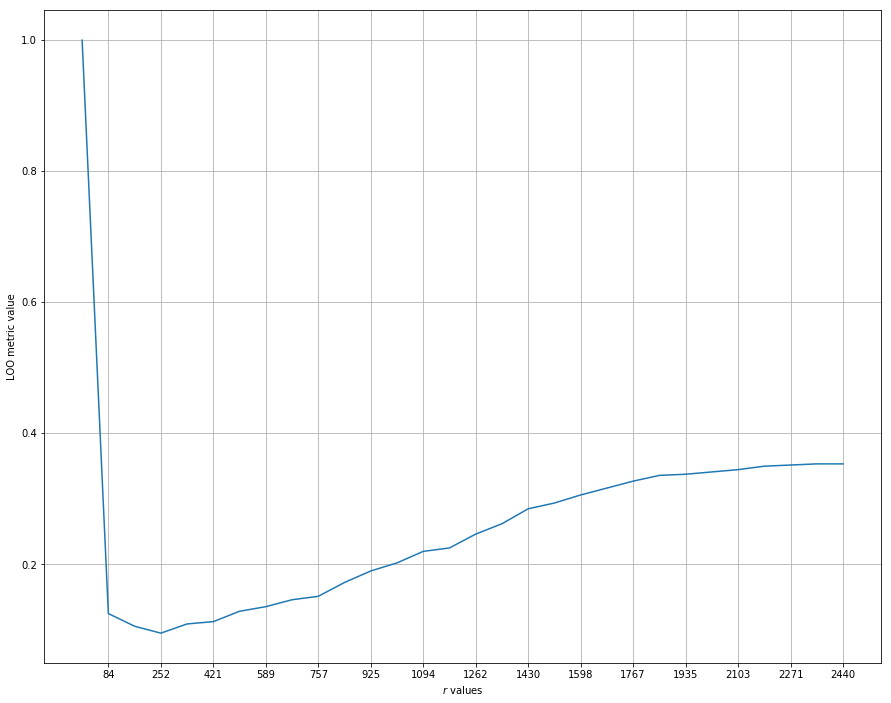

In [102]:
fig, ax = plt.subplots(figsize=[15, 12])
ax.plot(lval_c, LOOs_c)
ax.set_xticks(lval_c[1::2])
ax.grid()
ax.set_xlabel('$r$ values')
_ = ax.set_ylabel('LOO metric value')

It seems that the minimum of LOO function is around the value of $r=252$.

The same procedure will be performed on the spam data set:

In [103]:
m1 = Train_s.loc[Train_s['label']==1, :].drop(columns='label')
print(dm1.shape)
m0 = Train_s.loc[Train_s['label']==0, :].drop(columns='label')
print(dm0.shape)
dm1 = distance_matrix(m1, m1)
dm0 = distance_matrix(m0, m0)
print(f'Mean distance between objects in benign cathegory = {np.mean(dm1)}')
print(f'Mean distance between objects in malignant cathegory = {np.mean(dm0)}')
(np.mean(dm1)+np.mean(dm0))/2

(285, 285)
(170, 170)
Mean distance between objects in benign cathegory = 629.6307007130561
Mean distance between objects in malignant cathegory = 216.25155945935825


422.94113008620718

In [104]:
model = Neighbours_classifier(radius_weight, [421])
model.fit(Train_s, 'label')
probas_s = model.predict_proba(Test_s)
print(f'ROC-AUC score of the model: {roc_auc_score(Test_labels_s, probas_s.iloc[:,1])}')

Weightening done in 78.17111301422119 seconds
ROC-AUC score of the model: 0.7398965214214481


In [107]:
start_val = min(np.percentile(dm1, 2.5), np.percentile(dm0, 2.5))
end_val = max(np.percentile(dm1, 75), np.percentile(dm0, 75))
print(start_val)
print(end_val)
r_values = np.linspace(start_val, end_val, 30)

7.63755196382
806.318120965


In [108]:
model.fit(df_spam, 'label')
lval_s, LOOs_s = model.LOO(r_values)

Weightening done in 690.8349804878235 seconds


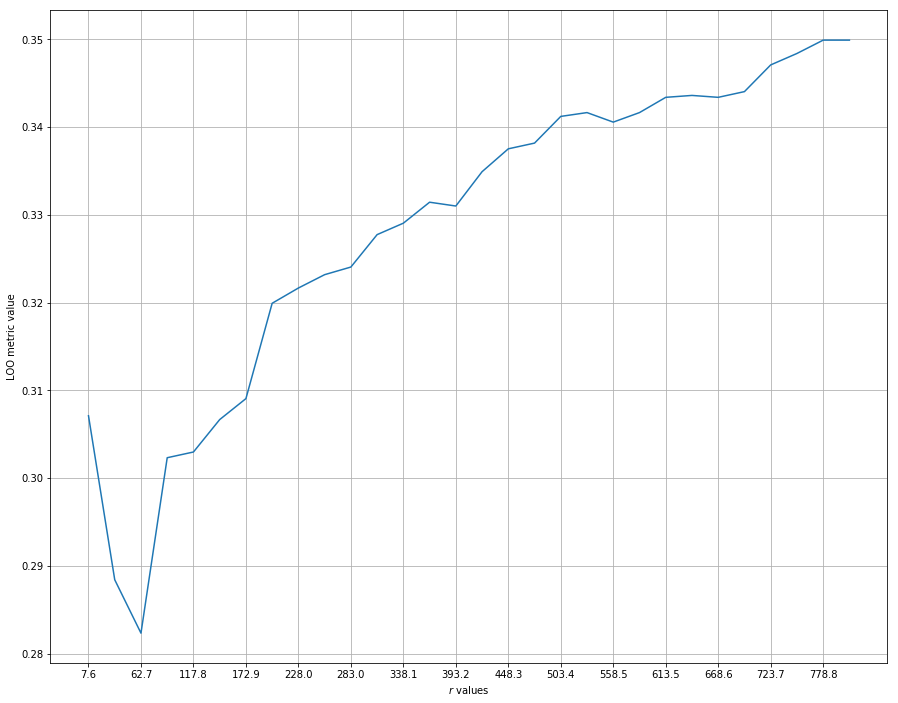

In [112]:
fig, ax = plt.subplots(figsize=[15, 12])
ax.plot(lval_s, LOOs_s)
ax.set_xticks(lval_s[::2])
ax.grid()
ax.set_xlabel('$r$ values')
_ = ax.set_ylabel('LOO metric value')

Minimum is around $r=62.7$.

# Normalization

Now the whole process will be repated for normalized data sets.

In [113]:
from sklearn.preprocessing import MinMaxScaler

In [116]:
scaler = MinMaxScaler()
tfd_cancer = scaler.fit_transform(df_cancer)
tfd_spam = scaler.fit_transform(df_spam)

In [125]:
tfd_cancer = pd.DataFrame(tfd_cancer, index=df_cancer.index, columns=df_cancer.columns)
tfd_spam = pd.DataFrame(tfd_spam, index=df_spam.index, columns=df_spam.columns)
tfd_cancer['label'] = tfd_cancer['label'].astype(int)
tfd_spam['label'] = tfd_spam['label'].astype(int)

In [128]:
model = Neighbours_classifier(radius_weight, [None])
model.fit(tfd_cancer, 'label')
lvls_c, LOOs_c = model.LOO(np.linspace(0, 1, 30))

Weightening done in 17.570146322250366 seconds


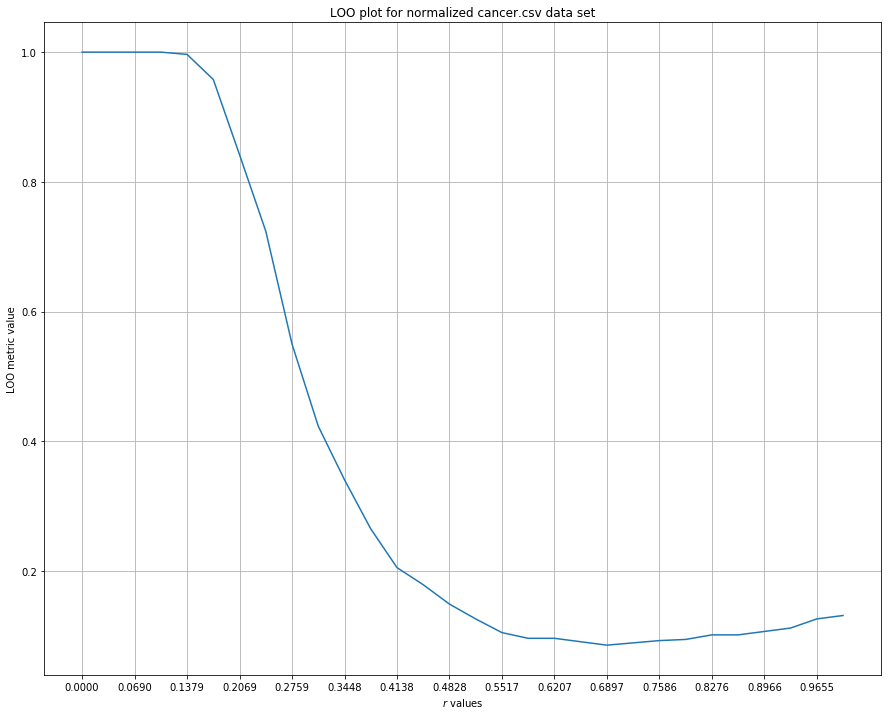

In [133]:
fig, ax = plt.subplots(figsize=[15, 12])
ax.plot(lvls_c, LOOs_c)
ax.set_xticks(lvls_c[::2])
ax.grid()
ax.set_title('LOO plot for normalized cancer.csv data set')
ax.set_xlabel('$r$ values')
_ = ax.set_ylabel('LOO metric value')

Minimum is around $r=0.69$.

In [134]:
model = Neighbours_classifier(radius_weight, [None])
model.fit(tfd_spam, 'label')
lvls_s, LOOs_s = model.LOO(np.linspace(0, 1, 20))

Weightening done in 296.4662926197052 seconds


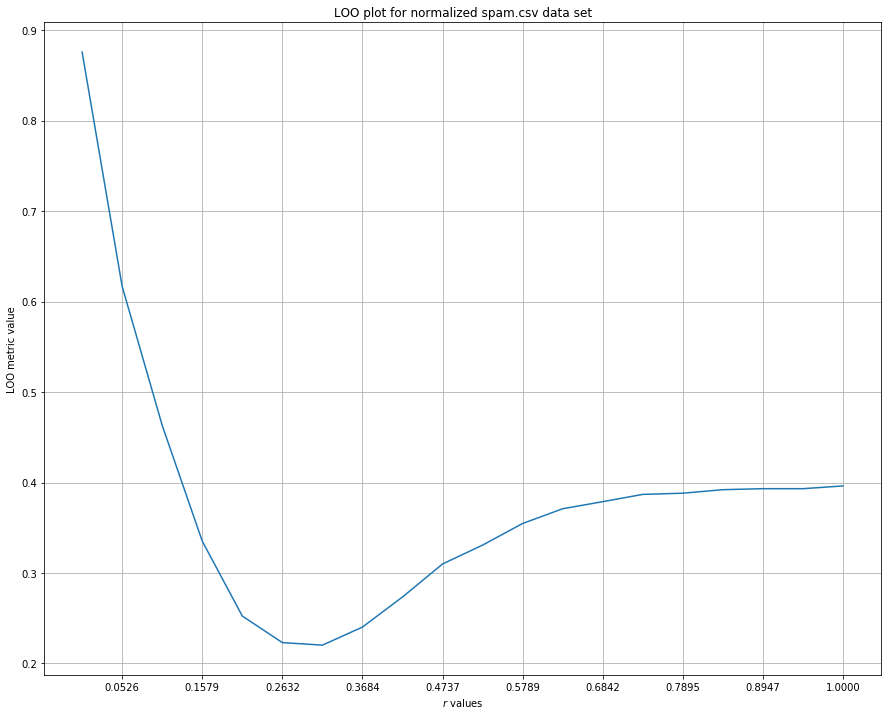

In [136]:
fig, ax = plt.subplots(figsize=[15, 12])
ax.plot(lvls_s, LOOs_s)
ax.set_xticks(lvls_s[1::2])
ax.grid()
ax.set_title('LOO plot for normalized spam.csv data set')
ax.set_xlabel('$r$ values')
_ = ax.set_ylabel('LOO metric value')

Minimum is around $r=0.2632$.